In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from ydata_profiling import ProfileReport

In [2]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
import geopandas as gpd

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

In [4]:
df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/train_cleaned.csv')

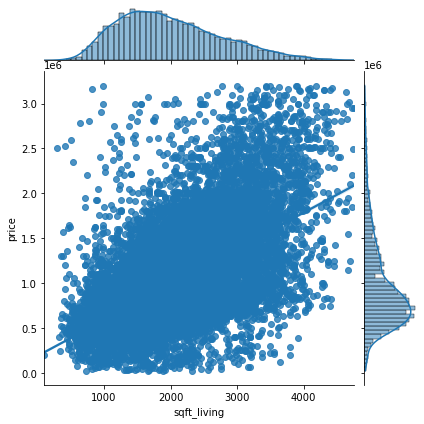

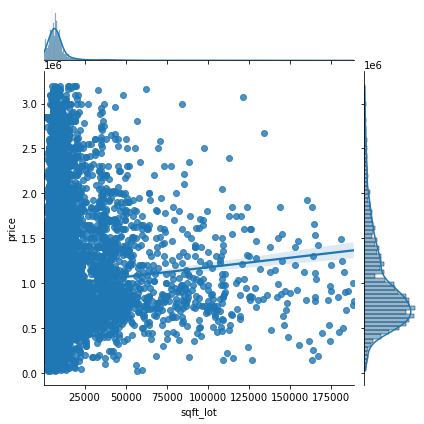

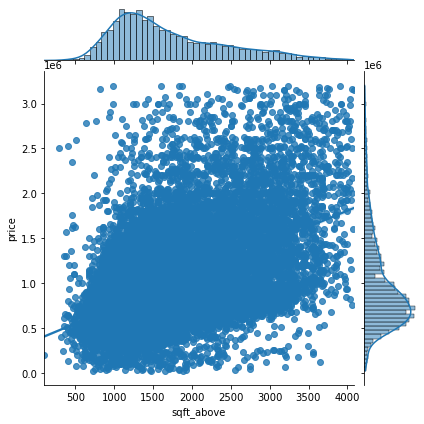

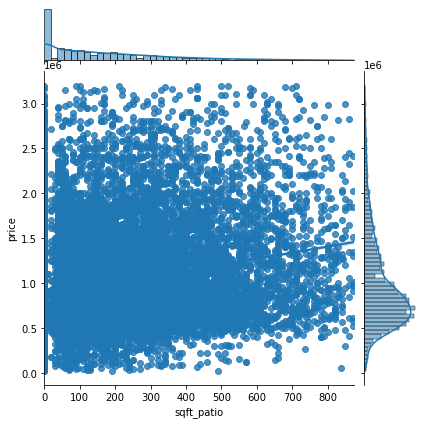

In [5]:
# We want to look at linearity of some select features vs our target variable, price
cont_feat = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_patio']


#  Plot jointplots
for feature in cont_feat:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

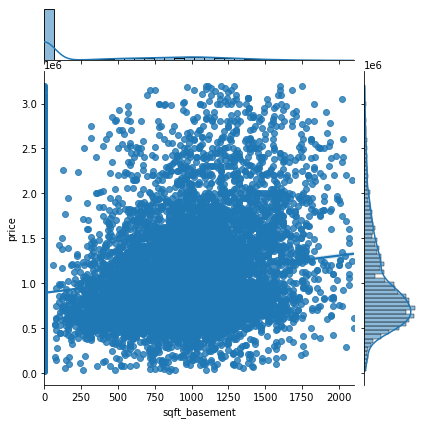

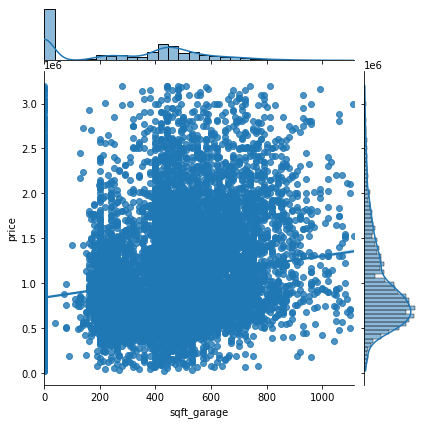

In [6]:
# let's look at linearity for some different continuous features

cont_feat_2 = ['sqft_basement', 'sqft_garage']


#  Plot jointplots
for feature in cont_feat_2:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

In [7]:
# we're getting really screwed up data due to the zeroes in the basement sq foot. we are unsure whether to leave this
# column and calculate its mean, or create a new column of the mean with just those places that have a basement

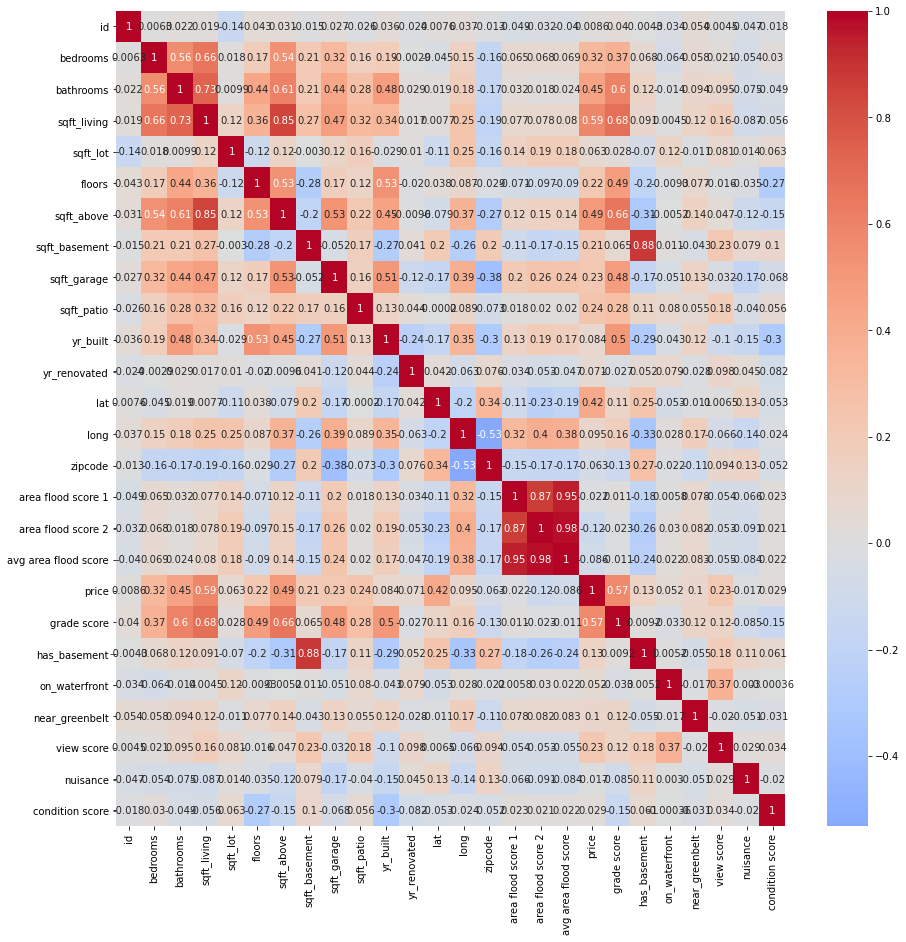

In [8]:
# done with continuous variables, so let's look again at multicollinearity using heatmaps

corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [9]:
# gonna drop sq_basement, since it is so highly correlated with "has_basement" AND so few have basements that it
# really skews the mean

In [10]:
df.drop(labels='sqft_basement', axis=1, inplace=True)

In [11]:
# sqft_above is also fairly strongly correlated AND isn't super-relevant for our purposes
df.drop(labels='sqft_above', axis=1, inplace=True)

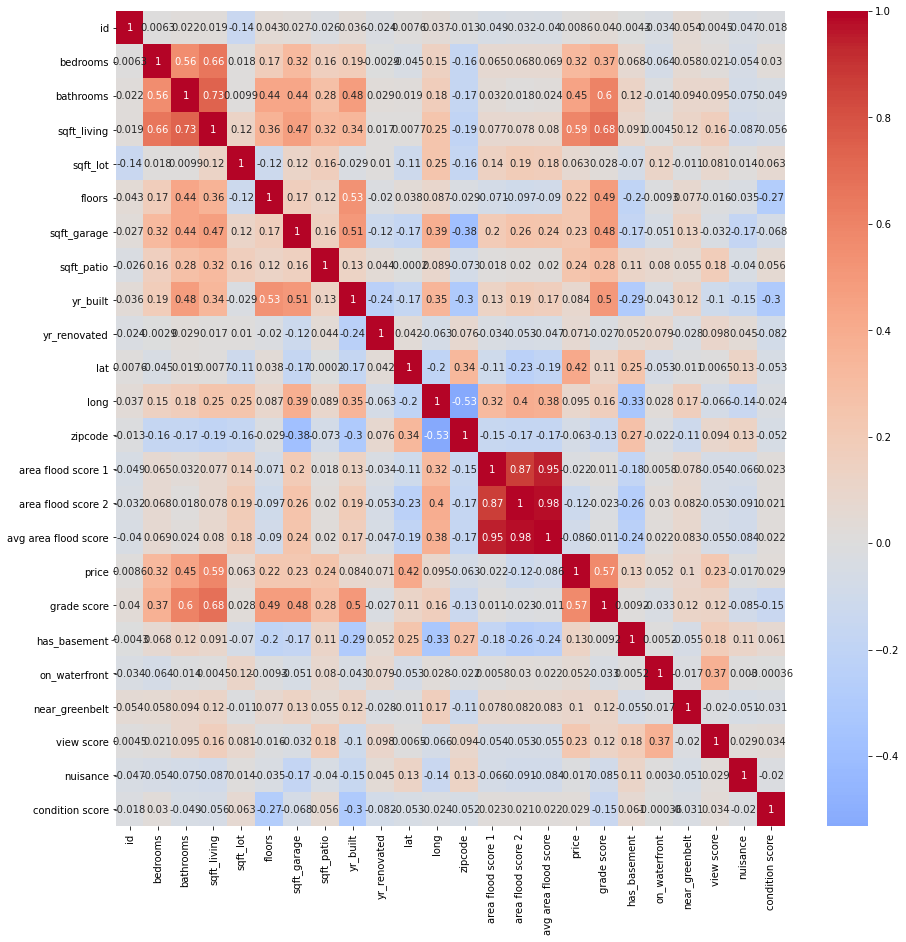

In [12]:
#let's get a new heatmap

new_corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(new_corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [13]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# https://www.statology.org/how-to-calculate-vif-in-python/

y, X = dmatrices('sqft_living ~ bedrooms+bathrooms', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,15.868828,Intercept
1,1.447613,bedrooms
2,1.447613,bathrooms


In [14]:
# our VIF scores aren't bad (2-5 is moderate). let's try this again for a few other variables

In [15]:
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'heat_source', 'sewer_system', 'sqft_garage', 'sqft_patio',
       'yr_built', 'yr_renovated', 'lat', 'long', 'street address', 'city',
       'zipcode', 'floodzones in zipcode', 'area flood score 1',
       'area flood score 2', 'avg area flood score', 'price', 'grade score',
       'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance', 'condition score'],
      dtype='object')

In [16]:
df.rename(columns={'area flood score 1': 'area_flood_score_max', 'area flood score 2':'area_flood_score_min', 
                   'avg area flood score':'avg_area_flood_score'}, inplace=True)

In [17]:
df.rename(columns={'floodzones in zipcode': 'floodzones_in_zipcode'}, inplace=True)

In [18]:
y, X = dmatrices('area_flood_score_max ~  area_flood_score_min+avg_area_flood_score', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,94.865676,Intercept
1,27.516518,area_flood_score_min
2,27.516518,avg_area_flood_score


In [19]:
# very high VIF scores for our flood data, but should we drop? unsure how to handle
# overall, VIF scores are superior to correlation data, per https://online.stat.psu.edu/stat462/node/180/

In [20]:
#gonna leave them for now. resaving this training data

df.to_csv('cleaned_training_2.csv')

In [21]:
# now that we have a new dataframe, let's open it, and run some regressions

In [22]:
df_2 = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/cleaned_training_2.csv')

In [24]:
df_2.head()

,Unnamed: 0,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,...,area_flood_score_min,avg_area_flood_score,price,grade score,has_basement,on_waterfront,near_greenbelt,view score,nuisance,condition score
0,0,4322300140,2022-01-17,3,2.5,1979,13439,1.0,280,280,...,1.000000,1.500000,600000.0,7,1,0,0,0,0,5
1,1,3928000040,2021-11-03,4,3.0,2450,8772,2.0,460,460,...,1.800000,1.900000,698507.0,8,0,0,0,0,0,3
2,2,3359500340,2021-09-20,3,1.0,1100,3000,1.0,0,0,...,1.666667,1.833333,686500.0,6,0,0,0,0,1,3
3,3,3629200040,2022-03-30,4,3.0,3800,10194,1.0,580,0,...,1.000000,1.500000,2720000.0,9,1,0,0,0,0,3
4,4,5469501620,2022-05-19,4,3.5,3840,15347,1.0,580,690,...,2.333333,2.500000,900000.0,9,1,0,0,2,0,4


In [25]:
# finally, let's get into models!

In [26]:
X_train = np.array(df_2['sqft_living']).reshape(-1, 1)
y_train = df_2['price']
X_train

array([[1979],
       [2450],
       [1100],
       ...,
       [2560],
       [2560],
       [ 840]])

In [27]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6295.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:00   Log-Likelihood:            -1.2576e+05
No. Observations:                8669   AIC:                         2.515e+05
Df Residuals:                    8667   BIC:                         2.515e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.25e+05   1.28e+04      9.726      0.000    9.98e+04     1.5e+05
x1           442.5201      5.578     79.339      0.000     431.587     453.453
==============================================================================
Omnibus:                     2134.389   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7906.861
Skew:                           1.196   Prob(JB):                         0.00
Kurtosis:                       7.022   Cond. No.                     5.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# our R2 is very low. let's try another model

In [29]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Evaluate using rmse
scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)
# ValueError: Expected 2D array, got 1D array instead:
#array=[1420 4100 2170 ... 1350 2280 2310].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [30]:
rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())


array([485644.31560028, 473298.22208867, 505589.61633801, 520413.68557168,
       503189.49483813, 461687.5450131 , 449399.99647434, 485368.67782267,
       465771.1501078 , 478824.21856612])

482918.6922420816

20788.946954102834

In [31]:
# mean error is 424k! std is 12105. that's pretty large. we can imagine this would happen because
# king county is so large and has a lot of variation. small places in seattle would sell for a lot more
# than large places in less-desirable areas. let's add more features

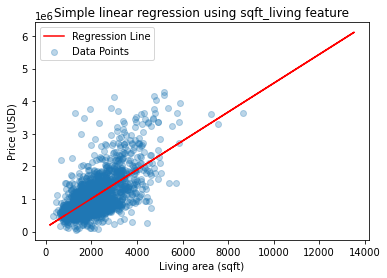

In [32]:
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'red', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_living feature')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()

In [33]:
#where did this unnamed column come from? let's get rid of it
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [34]:
# so size isn't super-relevant for king county. let's look at area. we need to drop all area info in 
# order to get our base model. let's also remove object data, since the model can't handle it
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date'], axis=1)
y_train = df_2['price']



In [35]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     578.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2457e+05
No. Observations:                8669   AIC:                         2.492e+05
Df Residuals:                    8649   BIC:                         2.493e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.628e+06 

In [36]:
#well, our model isn't very predictive. probably due to the multicollinearity with the flood data? look at "cond. no."

In [37]:
#let's try removing it

In [38]:
X_train = df_2.drop(['area_flood_score_min','area_flood_score_max', 'avg_area_flood_score','price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date', ], axis=1)
y_train = df_2['price']

In [39]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     591.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2479e+05
No. Observations:                8669   AIC:                         2.496e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.535e+06   4.45e+05     

In [40]:
# welp ,that made it worse!! let's re-add those (and convert objects to categoricals)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8669 entries, 0 to 8668
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8669 non-null   int64  
 1   date                   8669 non-null   object 
 2   bedrooms               8669 non-null   int64  
 3   bathrooms              8669 non-null   float64
 4   sqft_living            8669 non-null   int64  
 5   sqft_lot               8669 non-null   int64  
 6   floors                 8669 non-null   float64
 7   sqft_garage            8669 non-null   int64  
 8   sqft_patio             8669 non-null   int64  
 9   yr_built               8669 non-null   int64  
 10  yr_renovated           8669 non-null   int64  
 11  lat                    8669 non-null   float64
 12  long                   8669 non-null   float64
 13  street address         8669 non-null   object 
 14  city                   8669 non-null   object 
 15  zipc

In [41]:
df_2['street address'] = df_2['street address'].astype('category')
df_2['city'] = df_2['city'].astype('category')
df_2['floodzones_in_zipcode'] = df_2['floodzones_in_zipcode'].astype('category')



In [42]:
df_2.drop(columns=['id', 'date'], axis=1, inplace=True)

In [43]:
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode' ], axis=1)
y_train = df_2['price']

In [44]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     609.7
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2458e+05
No. Observations:                8669   AIC:                         2.492e+05
Df Residuals:                    8650   BIC:                         2.493e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.616e+06 

In [45]:
# let's boost this by just looking at one flood score at a time

X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'area_flood_score_max'], axis=1)
y_train = df_2['price']

In [46]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     601.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2475e+05
No. Observations:                8669   AIC:                         2.495e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.166e+06 

In [47]:
#worse! 


X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']

In [48]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     591.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2479e+05
No. Observations:                8669   AIC:                         2.496e+05
Df Residuals:                    8651   BIC:                         2.497e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   7.5e+06 

In [49]:
# even worse! finally, let's remove the max and area score
#(note, however, that our cond no. scores are dropping)

X_train = df_2.drop(['price','lat', 'long', 'zipcode',  'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']


In [50]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     611.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2471e+05
No. Observations:                8669   AIC:                         2.495e+05
Df Residuals:                    8651   BIC:                         2.496e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.815e+06 

In [51]:
#better! min score is more predictive!, with the same cond no. 

In [52]:
#let's do some onehot encoding

def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [53]:
onehot_df = one_hot_encode(df_2, ['grade score', 'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance'])
onehot_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,...,grade score_12,grade score_13,has_basement_1,on_waterfront_1,near_greenbelt_1,view score_1,view score_2,view score_3,view score_4,nuisance_1
0,3,2.5,1979,13439,1.0,280,280,1963,0,47.281065,...,0,0,1,0,0,0,0,0,0,0
1,4,3.0,2450,8772,2.0,460,460,2021,0,47.192910,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1100,3000,1.0,0,0,1911,0,47.673490,...,0,0,0,0,0,0,0,0,0,1
3,4,3.0,3800,10194,1.0,580,0,1975,2006,47.532310,...,0,0,1,0,0,0,0,0,0,0
4,4,3.5,3840,15347,1.0,580,690,1976,0,47.382170,...,0,0,1,0,0,0,1,0,0,0


In [54]:
#let's try linear and mulilinear with this onehot encoded values

In [55]:
X_train = onehot_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df['price']

In [56]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     382.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:01   Log-Likelihood:            -1.2446e+05
No. Observations:                8669   AIC:                         2.490e+05
Df Residuals:                    8638   BIC:                         2.492e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.798e+06   6.12e+05     11.102      0.000     5.6e+06       8e+06
bedrooms             -2.221e+04   6556.349     -3.388      0.001   -3.51e+04   -9359.010
bathrooms             7.347e+04   9395.902      7.819      0.000    5.51e+04    9.19e+04
sqft_living            218.3676     10.553     20.693      0.000     197.682     239.054
sqft_lot                 0.0521      0.075      0.696      0.486      -0.095       0.199
floors               -1.867e+04   1.12e+04     -1.675      0.094   -4.05e+04    3184.660
sqft_garage            -13.3343     21.481     -0.621      0.535     -55.443      28.774
sqft_patio               4.2857     21.376      0.200      0.841     -37.617      46.189
yr_built             -3314.5540    227.996    -14.538      0.000   -3761.481   -2867.627
yr_renovated            68.9199     11.635      5.924      0.000      46.113      91.727
area_flood_score_min -1.301e+05   9978.266    -13.037      0.000    -1.5e+05   -1.11e+05
condition score       3.987e+04   6933.611      5.750      0.000    2.63e+04    5.35e+04
grade score_3        -1.275e+05   5.13e+05     -0.249      0.804   -1.13e+06    8.77e+05
grade score_4           9.5e+04   4.38e+05      0.217      0.828   -7.63e+05    9.53e+05
grade score_5         1.164e+05   4.21e+05      0.276      0.782   -7.09e+05    9.42e+05
grade score_6         7.717e+04    4.2e+05      0.184      0.854   -7.46e+05       9e+05
grade score_7         1.947e+05    4.2e+05      0.464      0.643   -6.29e+05    1.02e+06
grade score_8         3.713e+05    4.2e+05      0.884      0.377   -4.52e+05    1.19e+06
grade score_9         7.269e+05    4.2e+05      1.729      0.084   -9.74e+04    1.55e+06
grade score_10        1.204e+06   4.21e+05      2.860      0.004    3.79e+05    2.03e+06
grade score_11        1.492e+06   4.23e+05      3.524      0.000    6.62e+05    2.32e+06
grade score_12        1.437e+06   4.32e+05      3.327      0.001     5.9e+05    2.28e+06
grade score_13        1.724e+06   4.63e+05      3.722      0.000    8.16e+05    2.63e+06
has_basement_1       -1.198e+04   1.05e+04     -1.139      0.255   -3.26e+04    8643.395
on_waterfront_1       5.559e+04   4.41e+04      1.262      0.207   -3.08e+04    1.42e+05
near_greenbelt_1      9.555e+04   2.87e+04      3.333      0.001    3.93e+04    1.52e+05
view score_1          1.652e+05   5.44e+04      3.038      0.002    5.86e+04    2.72e+05
view score_2          5.465e+04   1.89e+04      2.888      0.004    1.76e+04    9.17e+04
view score_3          5.614e+04   2.72e+04      2.061      0.039    2736.743     1.1e+05
view score_4          3.426e+05   4.28e+04      8.006      0.000    2.59e+05    4.26e+05
nuisance_1             1.19e+04   1.23e+04      0.970      0.332   -1.21e+04    3.59e+04
=========================================================

In [57]:
# well, we got a tiny R2 improvement, though cond no increased. maybe we need more one-hot encoding?

In [58]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([420503.72170214, 408432.62509717, 429445.86753372, 456642.56871878,
       424838.23581092, 405227.44453477, 380331.94050035, 417708.20666884,
       404275.30997425, 433948.50740498])

418135.4427945923

19476.820415193466

In [59]:
# our RMSE scores improved in one respect but the std increased

In [60]:
# let's try onehot encoding more

In [61]:
catcols = ['bedrooms', 'bathrooms', 'floors']

In [62]:
onehot_df_2 = one_hot_encode(onehot_df, catcols)

In [63]:
X_train = onehot_df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df_2['price']

In [64]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     196.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:02   Log-Likelihood:            -1.2439e+05
No. Observations:                8669   AIC:                         2.489e+05
Df Residuals:                    8608   BIC:                         2.493e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.081e+06   6.35e+05     11.159      0.000    5.84e+06    8.33e+06
sqft_living            211.9854     10.842     19.552      0.000     190.732     233.239
sqft_lot                 0.0957      0.075      1.280      0.201      -0.051       0.242
sqft_garage              6.6015     22.019      0.300      0.764     -36.562      49.765
sqft_patio              -1.2154     21.368     -0.057      0.955     -43.101      40.671
yr_built             -3469.0632    243.388    -14.253      0.000   -3946.161   -2991.965
yr_renovated            68.8020     11.667      5.897      0.000      45.933      91.671
area_flood_score_min -1.271e+05   9973.471    -12.748      0.000   -1.47e+05   -1.08e+05
condition score       4.426e+04   6988.828      6.333      0.000    3.06e+04     5.8e+04
grade score_3         1.044e+05   5.65e+05      0.185      0.854      -1e+06    1.21e+06
grade score_4         2.359e+05   4.89e+05      0.483      0.629   -7.22e+05    1.19e+06
grade score_5         3.527e+05   4.85e+05      0.728      0.467   -5.98e+05     1.3e+06
grade score_6          3.61e+05   4.84e+05      0.746      0.456   -5.87e+05    1.31e+06
grade score_7         5.044e+05   4.84e+05      1.043      0.297   -4.44e+05    1.45e+06
grade score_8         6.907e+05   4.84e+05      1.428      0.153   -2.58e+05    1.64e+06
grade score_9         1.033e+06   4.84e+05      2.133      0.033    8.39e+04    1.98e+06
grade score_10        1.477e+06   4.85e+05      3.046      0.002    5.26e+05    2.43e+06
grade score_11        1.755e+06   4.87e+05      3.605      0.000    8.01e+05    2.71e+06
grade score_12         1.74e+06   4.95e+05      3.515      0.000     7.7e+05    2.71e+06
grade score_13        1.968e+06   5.27e+05      3.732      0.000    9.35e+05       3e+06
has_basement_1       -1.046e+04   1.06e+04     -0.985      0.325   -3.13e+04    1.04e+04
on_waterfront_1       4.354e+04    4.4e+04      0.989      0.323   -4.27e+04     1.3e+05
near_greenbelt_1       9.48e+04   2.85e+04      3.321      0.001    3.88e+04    1.51e+05
view score_1          1.587e+05   5.42e+04      2.928      0.003    5.24e+04    2.65e+05
view score_2          5.257e+04   1.88e+04      2.792      0.005    1.57e+04    8.95e+04
view score_3          5.212e+04   2.71e+04      1.922      0.055   -1043.710    1.05e+05
view score_4            3.6e+05   4.28e+04      8.412      0.000    2.76e+05    4.44e+05
nuisance_1            1.157e+04   1.22e+04      0.946      0.344   -1.24e+04    3.55e+04
bedrooms_1           -5.508e+05   1.91e+05     -2.890      0.004   -9.24e+05   -1.77e+05
bedrooms_2           -6.684e+05   1.87e+05     -3.580      0.000   -1.03e+06   -3.02e+05
bedrooms_3           -6.799e+05   1.87e+05     -3.642      0.000   -1.05e+06   -3.14e+05
bedrooms_4           -6.995e+05   1.87e+05     -3.739    

In [65]:
# we've inched up, but not by much. we still have a lot of multicollinearity. clearly area matters but there's
#maybe too much variety within a zipcode
# let's try getting neighborhood data using geo location

In [66]:
def neighborhood_feat(df):
   
    
    # Define coord column with lat and long
    df['coord'] = list(zip(df['lat'], df['long']))
    
    # Use reverse geocoder
    results = rg.search(list(df['coord']))
    
    # Define neighbourhood list
    neighborhoods = [results[i]['name'] for i in range(0, len(results))]
    
    # Add neighbourhood feature
    df['neighborhood'] = neighborhoods
    
    return df

In [67]:
neighborhood_df = onehot_df_2.copy()

In [68]:
neighborhood_df = neighborhood_feat(neighborhood_df)

Loading formatted geocoded file...


In [69]:
#neighborhood_df = neighborhood_df .drop(['coord', 'lat', 'long', 'zipcode'], axis = 1)
# dropping multicollinearity features
onehot_neighborhood_df = one_hot_encode(neighborhood_df, 'neighborhood')
# Check 


In [70]:
onehot_neighborhood_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8669 entries, 0 to 8668
Columns: 149 entries, sqft_living to Yarrow Point
dtypes: category(3), float64(6), int64(8), object(1), uint8(131)
memory usage: 2.5+ MB


In [71]:
onehot_neighborhood_df

,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,street address,city,...,Tacoma,Tanner,Tukwila,Union Hill-Novelty Hill,Vashon,West Lake Sammamish,White Center,Woodinville,Woodway,Yarrow Point
0,1979,13439,280,280,1963,0,47.281065,-122.298820,35770 27th Avenue South,Federal Way,...,0,0,0,0,0,0,0,0,0,0
1,2450,8772,460,460,2021,0,47.192910,-121.980870,243 Hogan Dr,Enumclaw,...,0,0,0,0,0,0,0,0,0,0
2,1100,3000,0,0,1911,0,47.673490,-122.323730,6045 5th Avenue Northeast,Seattle,...,0,0,0,0,0,0,0,0,0,0
3,3800,10194,580,0,1975,2006,47.532310,-122.226250,7815 85th Place Southeast,Mercer Island,...,0,0,0,0,0,0,0,0,0,0
4,3840,15347,580,690,1976,0,47.382170,-122.150270,14327 Southeast 243rd Street,Kent,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664,2050,6250,330,60,1940,0,47.568830,-122.402505,3916 55th Avenue Southwest,Seattle,...,0,0,0,0,0,0,1,0,0,0
8665,2150,1342,380,530,2021,0,47.593319,-122.294430,1101 Yakima Avenue South,Seattle,...,0,0,0,0,0,0,0,0,0,0
8666,2560,4116,510,260,2021,0,47.359860,-122.026100,27016 235th Place Southeast,Maple Valley,...,0,0,0,0,0,0,0,0,0,0
8667,2560,4547,410,170,2022,0,47.359710,-122.076180,27018 199th Avenue Southeast,Covington,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# well, that hardly helped. what is going on here? 

from geopy.distance import geodesic

In [73]:
seattle_lat = 47.6097
seattle_lon = -122.3331


In [74]:
onehot_neighborhood_df['distance from Seattle'] = onehot_neighborhood_df.apply(lambda row: geodesic((seattle_lat, seattle_lon), (row['lat'], row['long'])).miles, axis=1)

In [75]:
onehot_neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city',
       ...
       'Tanner', 'Tukwila', 'Union Hill-Novelty Hill', 'Vashon',
       'West Lake Sammamish', 'White Center', 'Woodinville', 'Woodway',
       'Yarrow Point', 'distance from Seattle'],
      dtype='object', length=150)

In [76]:
X_train = onehot_neighborhood_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['price']

In [77]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [78]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     184.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:55:06   Log-Likelihood:            -1.2209e+05
No. Observations:                8669   AIC:                         2.445e+05
Df Residuals:                    8528   BIC:                         2.455e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.285e+06   5.17e+05      4.419      0.000    1.27e+06     3.3e+06
sqft_living                 223.2605      8.582     26.015      0.000     206.438     240.084
sqft_lot                      0.3717      0.060      6.153      0.000       0.253       0.490
sqft_garage                  94.5324     17.824      5.304      0.000      59.593     129.472
sqft_patio                   -1.9629     16.697     -0.118      0.906     -34.694      30.768
yr_built                   -994.0148    201.196     -4.941      0.000   -1388.407    -599.623
yr_renovated                 77.4766      9.058      8.553      0.000      59.720      95.233
area_flood_score_min      -3.537e+04   1.19e+04     -2.972      0.003   -5.87e+04    -1.2e+04
condition score            5.732e+04   5516.025     10.391      0.000    4.65e+04    6.81e+04
grade score_3              3.676e+05    4.4e+05      0.836      0.403   -4.94e+05    1.23e+06
grade score_4              2.337e+05   3.83e+05      0.610      0.542   -5.17e+05    9.85e+05
grade score_5               3.46e+05   3.78e+05      0.915      0.360   -3.95e+05    1.09e+06
grade score_6              3.299e+05   3.77e+05      0.875      0.382   -4.09e+05    1.07e+06
grade score_7              3.632e+05   3.77e+05      0.963      0.336   -3.76e+05     1.1e+06
grade score_8              4.349e+05   3.77e+05      1.153      0.249   -3.05e+05    1.17e+06
grade score_9                6.4e+05   3.77e+05      1.695      0.090      -1e+05    1.38e+06
grade score_10             9.518e+05   3.78e+05      2.517      0.012    2.11e+05    1.69e+06
grade score_11             1.237e+06    3.8e+05      3.258      0.001    4.93e+05    1.98e+06
grade score_12             1.189e+06   3.86e+05      3.080      0.002    4.32e+05    1.95e+06
grade score_13             1.493e+06   4.11e+05      3.636      0.000    6.88e+05     2.3e+06
has_basement_1            -6.745e+04   8812.184     -7.654      0.000   -8.47e+04   -5.02e+04
on_waterfront_1            1.511e+05   3.47e+04      4.358      0.000    8.31e+04    2.19e+05
near_greenbelt_1           1.179e+04   2.26e+04      0.521      0.602   -3.25e+04    5.61e+04
view score_1               1.792e+05   4.22e+04      4.242      0.000    9.64e+04    2.62e+05
view score_2               7.552e+04   1.49e+04      5.084      0.000    4.64e+04    1.05e+05
view score_3               1.422e+05   2.13e+04      6.667      0.000       1e+05    1.84e+05
view score_4               4.587e+05   3.38e+04     13.561      0.000    3.92e+05    5.25e+05
nuisance_1                 -3.88e+04   9548.477     -4.063      0.000   -5.75e+04   -2.01e+04
bedrooms_1                 -5.16e+05   1.47e+05     -3.505      0.000   -8.05e+05   -2.27e+05
bedrooms_2                -5.896e+05   1.44e+05     -4.090      0.000   -8.

In [79]:
#well, this one variable is sorta powerful! neighborhood made all the difference

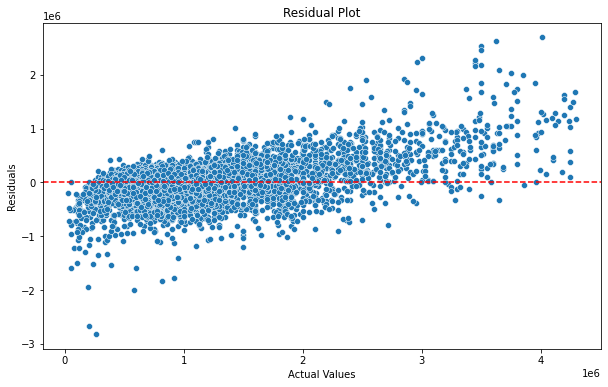

In [80]:
# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 720x432 with 0 Axes>

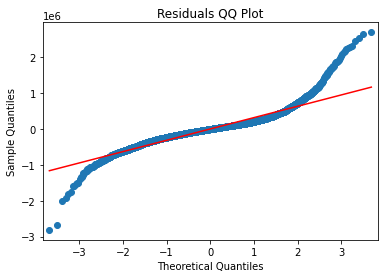

In [81]:
import statsmodels.graphics.gofplots as smg
residuals = model.resid

# Create a residuals QQ plot using statsmodels and matplotlib
plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

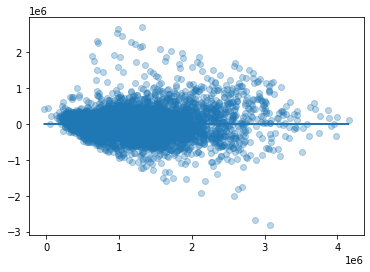

In [82]:
# our residuals still aren't great but let's check another aspect - homo- vs. heteroscedasticity

plt.scatter(model.predict(X_int), model.resid, alpha = 0.3)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()



In [83]:

# should we go back and log transform? probably in an ideal world, but this isn't too bad
# but let's experiment really quickly:
#log_price = np.log(price)

#neighborhood_df['log_price'] = price





In [85]:
#let's add this to the onehot model!

#onehot_neighborhood_df['log_price'] = price





In [86]:
# dropping multicollinnear features and object features to run model on neighborhoods data
X_train = onehot_neighborhood_df.drop(['log_price','price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['log_price']

KeyError: "['log_price'] not found in axis"

In [89]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     184.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:57:28   Log-Likelihood:            -1.2209e+05
No. Observations:                8669   AIC:                         2.445e+05
Df Residuals:                    8528   BIC:                         2.455e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.285e+06   5.17e+05      4.419      0.000    1.27e+06     3.3e+06
sqft_living                 223.2605      8.582     26.015      0.000     206.438     240.084
sqft_lot                      0.3717      0.060      6.153      0.000       0.253       0.490
sqft_garage                  94.5324     17.824      5.304      0.000      59.593     129.472
sqft_patio                   -1.9629     16.697     -0.118      0.906     -34.694      30.768
yr_built                   -994.0148    201.196     -4.941      0.000   -1388.407    -599.623
yr_renovated                 77.4766      9.058      8.553      0.000      59.720      95.233
area_flood_score_min      -3.537e+04   1.19e+04     -2.972      0.003   -5.87e+04    -1.2e+04
condition score            5.732e+04   5516.025     10.391      0.000    4.65e+04    6.81e+04
grade score_3              3.676e+05    4.4e+05      0.836      0.403   -4.94e+05    1.23e+06
grade score_4              2.337e+05   3.83e+05      0.610      0.542   -5.17e+05    9.85e+05
grade score_5               3.46e+05   3.78e+05      0.915      0.360   -3.95e+05    1.09e+06
grade score_6              3.299e+05   3.77e+05      0.875      0.382   -4.09e+05    1.07e+06
grade score_7              3.632e+05   3.77e+05      0.963      0.336   -3.76e+05     1.1e+06
grade score_8              4.349e+05   3.77e+05      1.153      0.249   -3.05e+05    1.17e+06
grade score_9                6.4e+05   3.77e+05      1.695      0.090      -1e+05    1.38e+06
grade score_10             9.518e+05   3.78e+05      2.517      0.012    2.11e+05    1.69e+06
grade score_11             1.237e+06    3.8e+05      3.258      0.001    4.93e+05    1.98e+06
grade score_12             1.189e+06   3.86e+05      3.080      0.002    4.32e+05    1.95e+06
grade score_13             1.493e+06   4.11e+05      3.636      0.000    6.88e+05     2.3e+06
has_basement_1            -6.745e+04   8812.184     -7.654      0.000   -8.47e+04   -5.02e+04
on_waterfront_1            1.511e+05   3.47e+04      4.358      0.000    8.31e+04    2.19e+05
near_greenbelt_1           1.179e+04   2.26e+04      0.521      0.602   -3.25e+04    5.61e+04
view score_1               1.792e+05   4.22e+04      4.242      0.000    9.64e+04    2.62e+05
view score_2               7.552e+04   1.49e+04      5.084      0.000    4.64e+04    1.05e+05
view score_3               1.422e+05   2.13e+04      6.667      0.000       1e+05    1.84e+05
view score_4               4.587e+05   3.38e+04     13.561      0.000    3.92e+05    5.25e+05
nuisance_1                 -3.88e+04   9548.477     -4.063      0.000   -5.75e+04   -2.01e+04
bedrooms_1                 -5.16e+05   1.47e+05     -3.505      0.000   -8.05e+05   -2.27e+05
bedrooms_2                -5.896e+05   1.44e+05     -4.090      0.000   -8.

In [ ]:
# well, our R2 is sthe same. cond isn't much better. let's look at residuals!
# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


<Figure size 720x432 with 0 Axes>

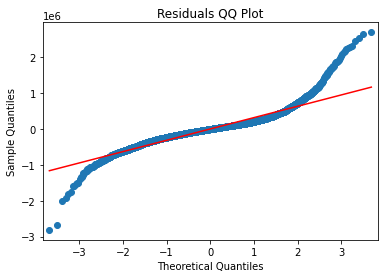

In [90]:
# log transform didn't do much. one last residual plot:

plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [97]:
# pretty much identical. let's get rid of log price

neighborhood_df.drop('log_price', axis= 1, inplace=True)
onehot_neighborhood_df.drop('log_price', axis= 1, inplace=True)

KeyError: "['log_price'] not found in axis"

In [98]:
# these are the top median neighborhoods by price 


test = neighborhood_df.groupby(neighborhood_df['neighborhood'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
test = test.reset_index()


test.iloc[:50]

,neighborhood,price
0,Clyde Hill,3220000.0
1,Medina,2820000.0
2,Kirkland,1900000.0
3,Yarrow Point,1850000.0
4,Ames Lake,1805000.0
5,Bellevue,1800000.0
6,Mercer Island,1700000.0
7,West Lake Sammamish,1680000.0
8,Maltby,1650000.0
9,Newport,1600000.0


In [ ]:
# these are the most flood-safe neighborhoods


test_2 = neighborhood_df.groupby(neighborhood_df['neighborhood'])['area_flood_score_min'].median().sort_values(ascending = True)

# Reset index after groupy
test_2 = test_2.reset_index()

test_2.iloc[:50]
# Reset index after groupy

In [99]:
#using least conservative flood score
# Group the 'Neighborhood' column by 'Price' (descending) and 'Flood_Score' (ascending)
grouped = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_min'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered = grouped[(grouped['price'] > grouped['price'].mean()) & (grouped['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods = filtered['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods)



['Ames Lake' 'Black Diamond' 'Bryn Mawr-Skyway' 'Buckley' 'Burien'
 'City of Sammamish' 'Clyde Hill' 'East Renton Highlands' 'Enumclaw'
 'Esperance' 'Fairwood' 'Federal Way' 'Fife Heights' 'Inglewood-Finn Hill'
 'Kingsgate' 'Kirkland' 'Lake Forest Park' 'Lake Morton-Berrydale'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'Tacoma' 'West Lake Sammamish' 'White Center' 'Woodway' 'Yarrow Point']


In [ ]:
# using the most conservative flood score

grouped_2 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_max'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_2 = grouped_2[(grouped['price'] > grouped_2['price'].mean()) & (grouped_2['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_2 = filtered_2['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_2)

In [93]:
# using the average flood score

grouped_3 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_3 = grouped_3[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_3 = filtered_3['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_3)

['Ames Lake' 'Black Diamond' 'Bryn Mawr-Skyway' 'Buckley' 'Burien'
 'City of Sammamish' 'Clyde Hill' 'East Renton Highlands' 'Enumclaw'
 'Esperance' 'Fairwood' 'Federal Way' 'Fife Heights' 'Inglewood-Finn Hill'
 'Kingsgate' 'Kirkland' 'Lake Forest Park' 'Lake Morton-Berrydale'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'Tacoma' 'West Lake Sammamish' 'White Center' 'Woodway' 'Yarrow Point']


In [ ]:
# they're all the same!

In [ ]:
# need to test, np. where eg column equals kirland, return flood score and then get the mean, min, max etc. 
# also check against MEDIAN values, different flood scores



#kirklandneighborhood_df.loc([neighborhood_df['neighborhood'] == 'Kirkland'


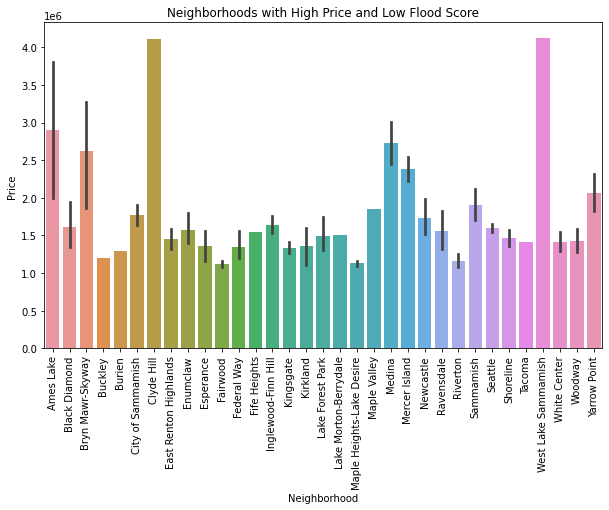

In [94]:
# let's get some visualizations for all our hard work!

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_3, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and Low Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# neighborhoods with high prices and high flood scores:

grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))

# Filter the neighborhoods with high price and low flood score
filtered_4 = grouped_4[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] > 2)]

# Retrieve the filtered neighborhoods
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_4)

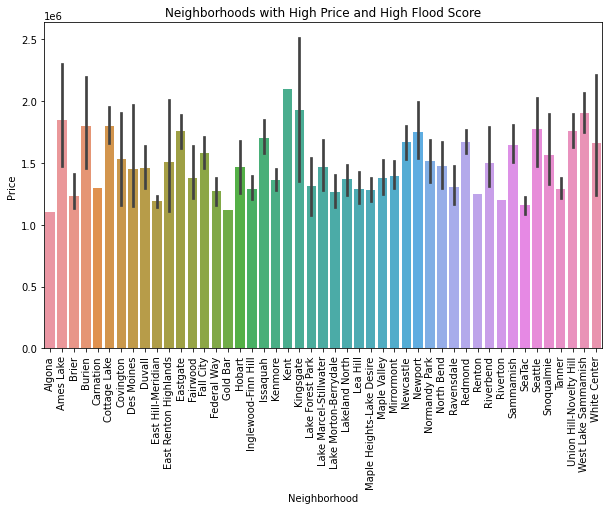

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the grouped_4 dataframe and filter the neighborhoods
grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))
filtered_4 = grouped_4[(grouped_4['price'] > grouped_4['price'].mean()) & (grouped_4['area_flood_score_min'] > 2)]
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_4, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and High Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# since we have a little time, we might want to look at another feature that appears highly correlated with price: 
# renovation year. let's look at recently renovated

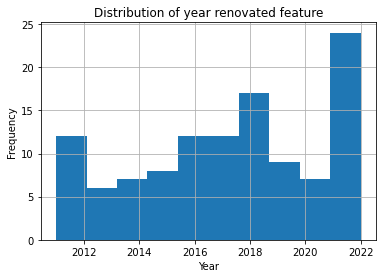

In [96]:
onehot_neighborhood_df[onehot_neighborhood_df['yr_renovated'] > 2010]['yr_renovated'].hist()
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("Distribution of year renovated feature")
plt.show()

In [ ]:
onehot_neighborhood_df = one_hot_encode(onehot_neighborhood_df, 'yr_renovated')
onehot_neighborhood_df.head()

In [ ]:
X_train = onehot_neighborhood_df.drop(['price', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['price']

In [ ]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

In [ ]:
# pretty good R2 still, even slightly highter than last. let's re-vamp out neighborhoods by flood score using this feature


In [ ]:
# we should look at recent renovations, since these are the highest in our distribution

filtered_3 = grouped_3[(grouped_3['price'] > grouped_3['price'].mean()) & 
                       (grouped_3['area_flood_score_min'] < 2) & 
                       (grouped_3['yr_renovated'] > 2010)]

# Retrieve the filtered neighborhoods
neighborhoods_3 = filtered_3['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_3)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_3, x='neighborhood', y='price')
plt.title('Above-Average Sale Price, Low Flood Score, and Recent Renovation')
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price in Millions of USD')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# these tend to be a bit more expensive, so should show the first graph vs this graph?

In [ ]:
test_df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/test_cleaned.csv')

In [ ]:
test_df.shape


In [ ]:
test_df.head()

In [87]:
#let's make sure this is different data. 

# Assuming df1 and df2 are the two dataframes
id_df1 = df['id']
id_df2 = test_df['id']

# Check if values in street_addresses_df1 are present in street_addresses_df2
is_present = id_df1.isin(id_df2)

# Print the results
print(is_present)
is_present.value_counts()

NameError: name 'test_df' is not defined

In [88]:
test_df.columns

NameError: name 'test_df' is not defined

In [ ]:
# ok, our test data was split properly. there are overlapping street addresses (98) but all IDs are unique. 
# the overlap is likely due to condos/apartments

